to check why prediction graph changed
1) data duplicates -> should not be the reason (data duplicates all from mucoco_splits which don't have data for 0.3 ~ 0.4)

In [1]:
# discretize toxicity columns and check distribution
# or simply check histogram
import pandas as pd
import seaborn as sns
import numpy as np
import torch

In [2]:
import os
os.getcwd()

'/home/hyeryungson/mucoco/notebooks'

In [3]:
os.chdir('/home/hyeryungson/mucoco')

In [4]:
data_dir = './data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/'

## Read data

In [5]:
all_data = pd.read_csv(os.path.join(data_dir, 'all_data_simple.csv'))

In [6]:
# remove rows that have both text and toxicity duplicated
print('nrows before drop duplicates by text column ', all_data.shape[0])
print('nrows after drop duplicates by text column', all_data.drop_duplicates(subset=['comment_text', 'toxicity']).shape[0])
print('nrows to be dropped ', all_data.shape[0] - all_data.drop_duplicates(subset=['comment_text', 'toxicity']).shape[0])

all_data = all_data.drop_duplicates(subset=['comment_text', 'toxicity'])

nrows before drop duplicates by text column  1999516
nrows after drop duplicates by text column 1977803
nrows to be dropped  21713


In [7]:
all_data['toxicity_cat']=pd.cut(all_data['toxicity'], np.arange(0, 1.11, 0.1), include_lowest=False, right=False)

In [8]:
# composition of toxicity label before deleting such dirty samples
def portion(x):
    return len(x)/len(all_data)
all_data.groupby('toxicity_cat').agg({'id': [len, portion]})

id          
                  len   portion
toxicity_cat                   
[0.0, 0.1)    1382741  0.699130
[0.1, 0.2)     177893  0.089945
[0.2, 0.3)     188465  0.095290
[0.3, 0.4)       6093  0.003081
[0.4, 0.5)      63108  0.031908
[0.5, 0.6)      79559  0.040226
[0.6, 0.7)      29662  0.014997
[0.7, 0.8)      16204  0.008193
[0.8, 0.9)      23878  0.012073
[0.9, 1.0)       5339  0.002699
[1.0, 1.1)       4861  0.002458

In [9]:
all_data = all_data.loc[~all_data['comment_text'].duplicated(keep=False)]

In [10]:
all_data=all_data.rename(columns={'comment_text': 'text'})

In [11]:
# drop nan row
all_data = all_data.loc[~all_data['text'].isna(),:].copy()

In [12]:
def portion(x):
    return len(x)/len(all_data)
all_data.groupby('toxicity_cat').agg({'id': [len, portion]})

id          
                  len   portion
toxicity_cat                   
[0.0, 0.1)    1380236  0.701493
[0.1, 0.2)     175909  0.089404
[0.2, 0.3)     186505  0.094790
[0.3, 0.4)       5991  0.003045
[0.4, 0.5)      62370  0.031699
[0.5, 0.6)      78504  0.039899
[0.6, 0.7)      29088  0.014784
[0.7, 0.8)      15841  0.008051
[0.8, 0.9)      23287  0.011835
[0.9, 1.0)       5063  0.002573
[1.0, 1.1)       4774  0.002426

In [13]:
all_data.shape

(1967568, 12)

/tmp/ipykernel_2317888/936240274.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_data['toxicity'], kde=False)


<Axes: xlabel='toxicity'>

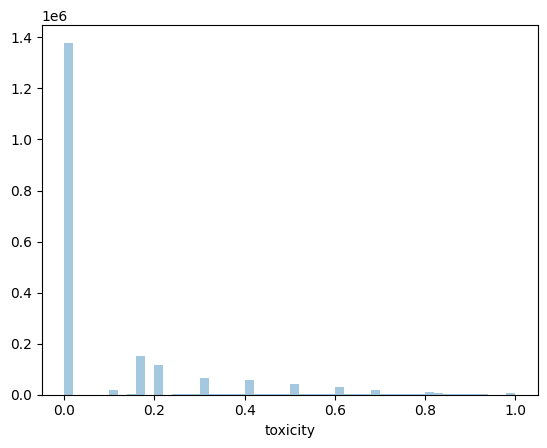

In [15]:
# highly imbalanced.
sns.distplot(all_data['toxicity'], kde=False)

## Set aside train, valid, test split of mucoco paper and add additional data (samples with (0, 0.5))

In [28]:
train0=pd.read_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/train_0.jsonl', lines=True)
train1=pd.read_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/train_1.jsonl', lines=True)

In [29]:
dev0=pd.read_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/dev_0.jsonl', lines=True)
dev1=pd.read_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/dev_1.jsonl', lines=True)

In [30]:
test0=pd.read_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/test_0.jsonl', lines=True)
test1=pd.read_json('/home/hyeryungson/mucoco/data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/test_1.jsonl', lines=True)

In [31]:
train0['split_mucoco'] = 'train'
train1['split_mucoco'] = 'train'
dev0['split_mucoco'] = 'dev'
dev1['split_mucoco'] = 'dev'
test0['split_mucoco'] = 'test'
test1['split_mucoco'] = 'test'

In [32]:
mucoco_splits=pd.concat([train0, train1, dev0, dev1, test0, test1], axis=0)
del train0, train1, dev0, dev1, test0, test1

In [20]:
mucoco_splits.duplicated().sum()

2631

In [21]:
print("before drop dup", mucoco_splits.shape)
mucoco_splits = mucoco_splits.drop_duplicates(); 
print("after drop dup", mucoco_splits.shape)

before drop dup (319564, 2)
after drop dup (316933, 2)


In [22]:
print("before merge all_data shape", all_data.shape)
all_data = all_data.merge(mucoco_splits, on='text', how='left')
print("after merge all_data shape", all_data.shape)

before merge all_data shape (1967568, 12)
after merge all_data shape (1967580, 13)


In [27]:
# duplicate between train and dev/test set => usu. toxicity 0.0 or 0.5
all_data.loc[all_data['text'].duplicated(keep=False), ['text', 'toxicity', 'split_mucoco']]

,text,toxicity,split_mucoco
13040,Off topic much?,0.0,train
13041,Off topic much?,0.0,test
23049,About time.,0.0,train
23050,About time.,0.0,dev
27428,Good!,0.0,train
27429,Good!,0.0,dev
38340,Right on.,0.0,train
38341,Right on.,0.0,test
83756,Right on!,0.0,train
83757,Right on!,0.0,dev


In [33]:
print("without drop up mucoco_splits")
print("before merge all_data shape", all_data.shape)
all_data = all_data.merge(mucoco_splits, on='text', how='left')
print("after merge all_data shape", all_data.shape)

without drop up mucoco_splits
before merge all_data shape (1967580, 13)
after merge all_data shape (1968073, 14)


In [40]:
all_data.loc[all_data['text'].duplicated(keep=False), ['text', 'toxicity', 'split_mucoco']].to_csv('notebooks/results/all_data_dup_check.csv')